## Introduction

For this project I will be tracking and predicting covid 19 infections, deaths, and vaccinations world wide. To begin I load in relevant libraries and the dataset.

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px
import plotly.graph_objects as go

from pmdarima.arima import auto_arima

from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('owid-covid-data.csv')
data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan  2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
0        1803.987              NaN                597.029   
1        1803.987              NaN                597.029   
2        1803.987              NaN                597.029   
3        1803.987              NaN                597.029   
4        1803.987              NaN                597.029   

   diabetes_prevalence  female_smokers  male_smokers  handwashing_facilities  \
0                 9.59             NaN           NaN                  37.746   
1                 9.59             NaN           NaN                  37.746   
2                 9.59             NaN           NaN                  37.746   
3                 9.59             NaN           NaN                  37.746   
4                 9.59             NaN           NaN                  37.746   

   hospital_beds_per_thousand  life_expectancy  human_development_index  
0                         0.5            64.83                    0.511  
1                         0.5            64.83                    0.511  
2                         0.5            64.83                    0.511  
3                         0.5            64.83                    0.511  
4                         0.5            64.83                    0.511  

[5 rows x 59 columns]

In [3]:
data.shape

(70444, 59)

## Data Cleaning

To begin, I am going to pull out the data pertaining to the United States, and the summary of covid data worldwide.

In [4]:
us_data = data[data.location == 'United States']
us_data.head()

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   
66765      USA  North America  United States  2020-01-23          1.0   
66766      USA  North America  United States  2020-01-24          2.0   
66767      USA  North America  United States  2020-01-25          2.0   
66768      USA  North America  United States  2020-01-26          5.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   
66765        0.0                 NaN           NaN         NaN   
66766        1.0                 NaN           NaN         NaN   
66767        0.0                 NaN           NaN         NaN   
66768        3.0                 NaN           NaN         NaN   

       new_deaths_smoothed  ...  gdp_per_capita  extreme_poverty  \
66764                  NaN  ...       54225.446              1.2   
66765                  NaN  ...       54225.446              1.2   
66766                  NaN  ...       54225.446              1.2   
66767                  NaN  ...       54225.446              1.2   
66768                  NaN  ...       54225.446              1.2   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
66764                151.089                10.79            19.1   
66765                151.089                10.79            19.1   
66766                151.089                10.79            19.1   
66767                151.089                10.79            19.1   
66768                151.089                10.79            19.1   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
66764          24.6                     NaN                        2.77   
66765          24.6                     NaN                        2.77   
66766          24.6                     NaN                        2.77   
66767          24.6                     NaN                        2.77   
66768          24.6                     NaN                        2.77   

       life_expectancy  human_development_index  
66764            78.86                    0.926  
66765            78.86                    0.926  
66766            78.86                    0.926  
66767            78.86                    0.926  
66768            78.86                    0.926  

[5 rows x 59 columns]

In [5]:
world_data = data[data.iso_code == 'OWID_WRL']
world_data.head()

iso_code continent location        date  total_cases  new_cases  \
69049  OWID_WRL       NaN    World  2020-01-22        557.0        0.0   
69050  OWID_WRL       NaN    World  2020-01-23        655.0       98.0   
69051  OWID_WRL       NaN    World  2020-01-24        941.0      286.0   
69052  OWID_WRL       NaN    World  2020-01-25       1433.0      492.0   
69053  OWID_WRL       NaN    World  2020-01-26       2118.0      685.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
69049                 NaN          17.0         0.0                  NaN  ...   
69050                 NaN          18.0         1.0                  NaN  ...   
69051                 NaN          26.0         8.0                  NaN  ...   
69052                 NaN          42.0        16.0                  NaN  ...   
69053                 NaN          56.0        14.0                  NaN  ...   

       gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
69049       15469.207             10.0                 233.07   
69050       15469.207             10.0                 233.07   
69051       15469.207             10.0                 233.07   
69052       15469.207             10.0                 233.07   
69053       15469.207             10.0                 233.07   

       diabetes_prevalence  female_smokers  male_smokers  \
69049                 8.51           6.434        34.635   
69050                 8.51           6.434        34.635   
69051                 8.51           6.434        34.635   
69052                 8.51           6.434        34.635   
69053                 8.51           6.434        34.635   

       handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
69049                   60.13                       2.705            72.58   
69050                   60.13                       2.705            72.58   
69051                   60.13                       2.705            72.58   
69052                   60.13                       2.705            72.58   
69053                   60.13                       2.705            72.58   

       human_development_index  
69049                    0.737  
69050                    0.737  
69051                    0.737  
69052                    0.737  
69053                    0.737  

[5 rows x 59 columns]

Now I will check for missing values in the us_data dataframe.

In [6]:
us_data.isna().sum()

iso_code                                   0
continent                                  0
location                                   0
date                                       0
total_cases                                0
new_cases                                  1
new_cases_smoothed                         6
total_deaths                              38
new_deaths                                38
new_deaths_smoothed                        6
total_cases_per_million                    0
new_cases_per_million                      1
new_cases_smoothed_per_million             6
total_deaths_per_million                  38
new_deaths_per_million                    38
new_deaths_smoothed_per_million            6
reproduction_rate                         44
icu_patients                              67
icu_patients_per_million                  67
hosp_patients                             58
hosp_patients_per_million                 58
weekly_icu_admissions                    347
weekly_icu

For now, we will need to look at the new_cases, total_deaths, new_deaths, new_cases_per_million, total_deaths_per_million, and new_deaths_per_million. I imagine that most of theses null values will be able to be substituted for zero, but I will take a closer look to make sure.

In [7]:
us_data[us_data.new_cases.isna()]

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   

       new_deaths_smoothed  ...  gdp_per_capita  extreme_poverty  \
66764                  NaN  ...       54225.446              1.2   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
66764                151.089                10.79            19.1   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
66764          24.6                     NaN                        2.77   

       life_expectancy  human_development_index  
66764            78.86                    0.926  

[1 rows x 59 columns]

The first data point in the us_data dataframe is the only null value for new cases. It also contains the only null value for new_cases_per_million. At this point there were no new cases. We can easily substitute a zero for both of these values.

In [8]:
us_data[us_data.total_deaths.isna()]

iso_code      continent       location        date  total_cases  \
66764      USA  North America  United States  2020-01-22          1.0   
66765      USA  North America  United States  2020-01-23          1.0   
66766      USA  North America  United States  2020-01-24          2.0   
66767      USA  North America  United States  2020-01-25          2.0   
66768      USA  North America  United States  2020-01-26          5.0   
66769      USA  North America  United States  2020-01-27          5.0   
66770      USA  North America  United States  2020-01-28          5.0   
66771      USA  North America  United States  2020-01-29          6.0   
66772      USA  North America  United States  2020-01-30          6.0   
66773      USA  North America  United States  2020-01-31          8.0   
66774      USA  North America  United States  2020-02-01          8.0   
66775      USA  North America  United States  2020-02-02          8.0   
66776      USA  North America  United States  2020-02-03         11.0   
66777      USA  North America  United States  2020-02-04         11.0   
66778      USA  North America  United States  2020-02-05         11.0   
66779      USA  North America  United States  2020-02-06         12.0   
66780      USA  North America  United States  2020-02-07         12.0   
66781      USA  North America  United States  2020-02-08         12.0   
66782      USA  North America  United States  2020-02-09         12.0   
66783      USA  North America  United States  2020-02-10         12.0   
66784      USA  North America  United States  2020-02-11         13.0   
66785      USA  North America  United States  2020-02-12         13.0   
66786      USA  North America  United States  2020-02-13         14.0   
66787      USA  North America  United States  2020-02-14         14.0   
66788      USA  North America  United States  2020-02-15         14.0   
66789      USA  North America  United States  2020-02-16         14.0   
66790      USA  North America  United States  2020-02-17         14.0   
66791      USA  North America  United States  2020-02-18         14.0   
66792      USA  North America  United States  2020-02-19         14.0   
66793      USA  North America  United States  2020-02-20         14.0   
66794      USA  North America  United States  2020-02-21         16.0   
66795      USA  North America  United States  2020-02-22         16.0   
66796      USA  North America  United States  2020-02-23         16.0   
66797      USA  North America  United States  2020-02-24         16.0   
66798      USA  North America  United States  2020-02-25         16.0   
66799      USA  North America  United States  2020-02-26         16.0   
66800      USA  North America  United States  2020-02-27         17.0   
66801      USA  North America  United States  2020-02-28         17.0   

       new_cases  new_cases_smoothed  total_deaths  new_deaths  \
66764        NaN                 NaN           NaN         NaN   
66765        0.0                 NaN           NaN         NaN   
66766        1.0                 NaN           NaN         NaN   
66767        0.0                 NaN           NaN         NaN   
66768        3.0                 NaN           NaN         NaN   
66769        0.0                 NaN           NaN         NaN   
66770        0.0               0.571           NaN         NaN   
66771        1.0               0.714           NaN         NaN   
66772        0.0               0.714           NaN         NaN   
66773        2.0               0.857           NaN         NaN   
66774        0.0               0.857           NaN         NaN   
66775        0.0               0.429           NaN         NaN   
66776        3.0               0.857           NaN         NaN   
66777        0.0               0.857           NaN         NaN   
66778        0.0               0.714           NaN         NaN   
66779        1.0               0.857           NaN         NaN   
66780        0.0               0.571

There are several things to note here. First the null values in total_deaths overlap completely with the null values in new_deaths, total_deaths_per_million, and new_deaths_per_million. These are the first 38 dates in the data set. At this point there were no deaths from Covid-19 in the United States. I will fill these null values with zero as well.

At this point, I am ready to fill the null values and drop several columns.

In [9]:
columns = ['new_cases', 'total_deaths', 'new_deaths', 'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million']
us_data[columns] = us_data[columns].fillna(0)
us_data=us_data.iloc[:,0:16]
us_data.isna().sum()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


iso_code                          0
continent                         0
location                          0
date                              0
total_cases                       0
new_cases                         0
new_cases_smoothed                6
total_deaths                      0
new_deaths                        0
new_deaths_smoothed               6
total_cases_per_million           0
new_cases_per_million             0
new_cases_smoothed_per_million    6
total_deaths_per_million          0
new_deaths_per_million            0
dtype: int64

In [10]:
us_data.date = pd.to_datetime(us_data.date)
us_data = us_data.set_index('date')
us_data.head()

iso_code      continent       location  total_cases  new_cases  \
date                                                                        
2020-01-22      USA  North America  United States          1.0        0.0   
2020-01-23      USA  North America  United States          1.0        0.0   
2020-01-24      USA  North America  United States          2.0        1.0   
2020-01-25      USA  North America  United States          2.0        0.0   
2020-01-26      USA  North America  United States          5.0        3.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-01-22                 NaN           0.0         0.0                  NaN   
2020-01-23                 NaN           0.0         0.0                  NaN   
2020-01-24                 NaN           0.0         0.0                  NaN   
2020-01-25                 NaN           0.0         0.0                  NaN   
2020-01-26                 NaN           0.0         0.0                  NaN   

            total_cases_per_million  new_cases_per_million  \
date                                                         
2020-01-22                    0.003                  0.000   
2020-01-23                    0.003                  0.000   
2020-01-24                    0.006                  0.003   
2020-01-25                    0.006                  0.000   
2020-01-26                    0.015                  0.009   

            new_cases_smoothed_per_million  total_deaths_per_million  \
date                                                                   
2020-01-22                             NaN                       0.0   
2020-01-23                             NaN                       0.0   
2020-01-24                             NaN                       0.0   
2020-01-25                             NaN                       0.0   
2020-01-26                             NaN                       0.0   

            new_deaths_per_million  
date                                
2020-01-22                     0.0  
2020-01-23                     0.0  
2020-01-24                     0.0  
2020-01-25                     0.0  
2020-01-26                     0.0

In [11]:
us_data.shape

(397, 14)

With the us_data dataframe ready for modeling, I will now look at the world dataframe.

In [12]:
world_data.isna().sum()

iso_code                                   0
continent                                397
location                                   0
date                                       0
total_cases                                0
new_cases                                  0
new_cases_smoothed                         6
total_deaths                               0
new_deaths                                 0
new_deaths_smoothed                        6
total_cases_per_million                    0
new_cases_per_million                      0
new_cases_smoothed_per_million             6
total_deaths_per_million                   0
new_deaths_per_million                     0
new_deaths_smoothed_per_million            6
reproduction_rate                          2
icu_patients                             397
icu_patients_per_million                 397
hosp_patients                            397
hosp_patients_per_million                397
weekly_icu_admissions                    397
weekly_icu

The world dataframe is already in good condition. There are no null values that we need to fill at this point. We only need to change our dates to datetimes and set them as the index.

In [13]:
world_data.date = pd.to_datetime(world_data.date)
world_data = world_data.set_index('date')

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## New and Total Cases

I will begin modeling by looking at the new and total numbers of cases. To get a good idea of what I am looking at, I will plot the total cases in the US and the total cases worldwide. I will look at both the straight number of cases and the number of cases per million people.

In [14]:
px.line(us_data.total_cases)

In [15]:
px.line(world_data.total_cases)

In [16]:
px.line(us_data.total_cases_per_million)

In [17]:
px.line(world_data.total_cases_per_million)

The shapes of the line graphs look pretty similar between the US and worldwide infection rates. Let's check the US infection time series for stationarity.

In [18]:
results = adfuller(us_data.total_cases)
results[1]

0.7360694958188174

As expected, the time series is not stationary. I will check for stationarity on the differenced time series, and if needed on the time series differenced twice.

In [19]:
results = adfuller(us_data.total_cases.diff().dropna())
results[1]

0.53765815648626

In [20]:
results = adfuller(us_data.total_cases.diff().diff().dropna())
results[1]

0.00048821931169533385

In [21]:
tot_cases = us_data.total_cases
diff_tot_cases = us_data.total_cases.diff().diff().dropna()

In [22]:
px.line(diff_tot_cases)

It looks like the time series needs to be differenced twice to become stationary. Now I will decompose the series to check for trend, and seasonality. I will decompose the initial series and the differenced series.

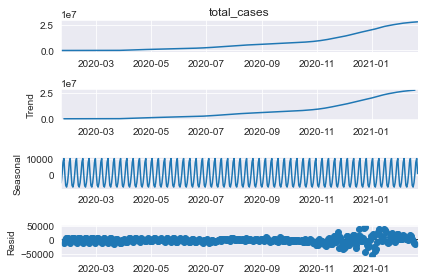

In [23]:
decomposed = sd(tot_cases)
decomposed.plot()
plt.show()

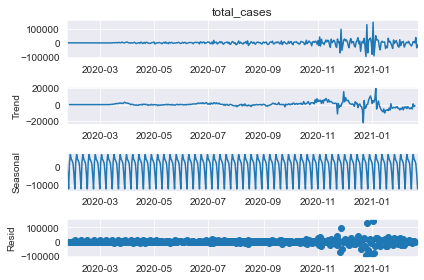

In [24]:
decomposed = sd(diff_tot_cases)
decomposed.plot()
plt.show()

It looks like there is a pretty obvious upwards trend to the original time series which is considerably smoothed out in the differenced time series. In both cases there is a fairly strong seasonal component equating to the days of the week. Now I will check the autocorrelation and partial autocorrelation plots.

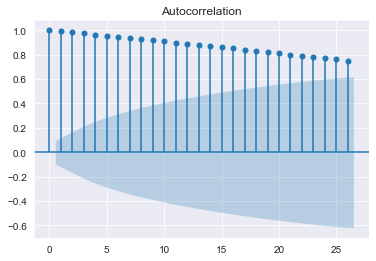

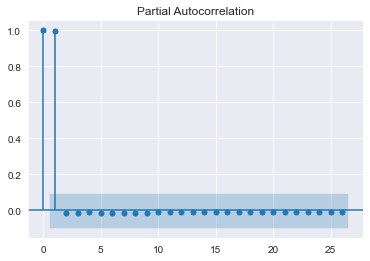

In [25]:
plot_acf(tot_cases)
plt.show()
plot_pacf(tot_cases)
plt.show()

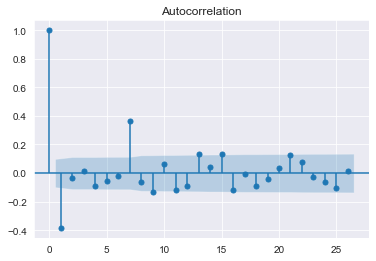

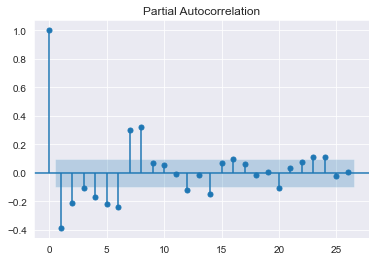

In [26]:
plot_acf(diff_tot_cases)
plt.show()
plot_pacf(diff_tot_cases)
plt.show()

The initial time series is pretty heavily autocorrelated, never dropping to insignificance. This is resolved in the differenced series as after the first lag, the resulting lags are all insignificant.

At this point I will separate the times series into training and test sets.

In [27]:
train = us_data.total_cases[:-30]
test = us_data.total_cases[-30:]

diff_train = diff_tot_cases[:-30]
diff_test = diff_tot_cases[-30:]

print('Length of training set: ', len(train))
print('Length of testing set: ', len(test))
print('Length of differenced training set: ', len(diff_train))
print('Length of differenced testing set: ', len(diff_test))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  365
Length of differenced testing set:  30


In [28]:
model = ExponentialSmoothing(diff_train, seasonal_periods=7).fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [29]:
yhat_estc = model.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_estc, diff_test))

In [30]:
print('Root Mean Squared Error: ', rmse)
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_estc.index,
                         y=yhat_estc,
                         mode='lines',
                         name='Predicted Total Cases'))


fig.show()

Root Mean Squared Error:  18572.62984319318


In [31]:
model = ExponentialSmoothing(diff_tot_cases, seasonal_periods=7).fit()

predictions_estc = model.predict(393, 423)

fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.total_cases.diff().diff().dropna(),
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x = predictions_estc.index,
                         y=predictions_estc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  365
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -4013.008
Date:                Thu, 25 Mar 2021   AIC                           8048.016
Time:                        16:35:36   BIC                           8090.915
Sample:                    01-24-2020   HQIC                          8065.065
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        520.5287    597.833      0.871      0.384    -651.203    1692.261
ar.L1         -0.4967      0.183     -2.713      0.007      -0.856      -0.138
ar.L2         -0.2528      0.097     -2.606      0.0

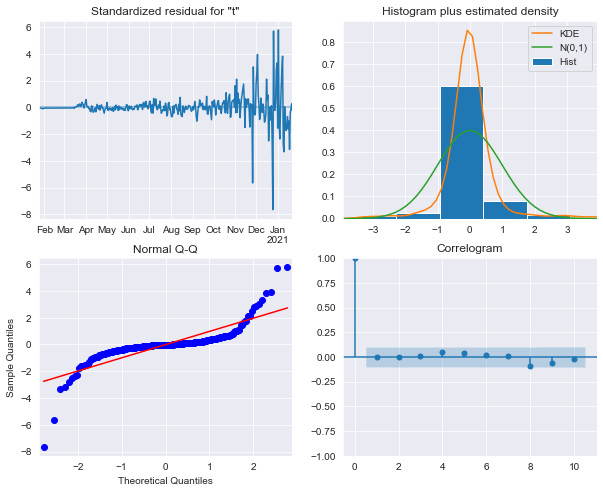

In [32]:
model = ARIMA(diff_train, order=(8,0,1), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [33]:
yhat_arima_tc = results.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_arima_tc, diff_test))

In [34]:
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_tc.index,
                         y=yhat_arima_tc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Squared Error:  16549.587594954744


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  395
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -4339.122
Date:                Thu, 25 Mar 2021   AIC                           8700.243
Time:                        16:35:39   BIC                           8744.011
Sample:                    01-24-2020   HQIC                          8717.584
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        143.0253    688.414      0.208      0.835   -1206.242    1492.293
ar.L1         -0.4049      0.138     -2.933      0.003      -0.675      -0.134
ar.L2         -0.1800      0.069     -2.608      0.0

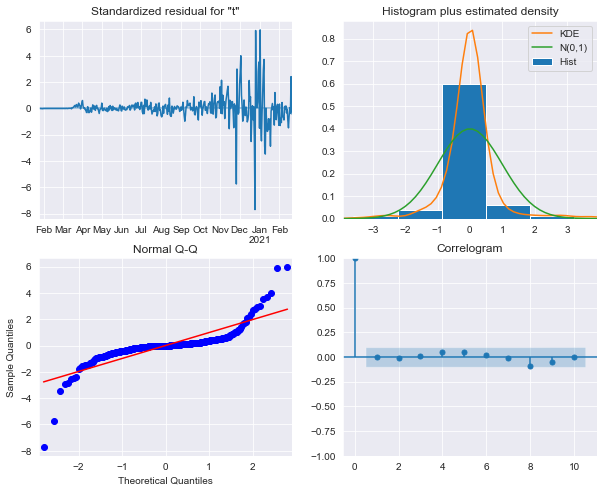

In [35]:
model = ARIMA(diff_tot_cases, order=(8,0,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [36]:
predictions_arima_tc = results.predict(394, 424)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_arima_tc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [37]:
auto_results_tc = auto_arima(train, m=7)
auto_results_tc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  367
Model:             SARIMAX(1, 2, 2)x(1, 0, [], 52)   Log Likelihood               -4043.758
Date:                             Thu, 25 Mar 2021   AIC                           8099.516
Time:                                     16:40:51   BIC                           8122.915
Sample:                                          0   HQIC                          8108.815
                                             - 367                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1324.5365    699.221      1.894      0.058     -45.911    2694.984
ar.L1         -0.8765      0.050    -17.408      0.000      -0.975      -0.778
ma.L1          0.3219      0.050      6.491      0.000       0.225       0.419
ma.L2         -0.5809      0.027    -21.482      0.000      -0.634      -0.528
ar.S.L52      -0.3609      0.039     -9.156      0.000      -0.438      -0.284
sigma2      2.635e+08      0.005   5.85e+10      0.000    2.64e+08    2.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              3021.65
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              91.45   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+26. Standard errors may be unstable.
"""

In [38]:
yhat_auto_tc = auto_results_tc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_auto_tc, test))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_tc.index,
                         y=yhat_auto_tc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Squared Error:  1095392.3922409522


In [39]:
auto_results_tc.fit(tot_cases)
predictions_atc = auto_results_tc.predict(n_periods = 30)

In [40]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_atc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [41]:
auto_results_diff_tc = auto_arima(diff_train, m=7, stepwise=True)
auto_results_diff_tc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  365
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood               -4044.099
Date:                             Thu, 25 Mar 2021   AIC                           8100.198
Time:                                     16:43:03   BIC                           8123.597
Sample:                                          0   HQIC                          8109.497
                                             - 365                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1324.5365    701.348      1.889      0.059     -50.081    2699.154
ar.L1         -0.8768      0.050    -17.440      0.000      -0.975      -0.778
ma.L1          0.3229      0.050      6.512      0.000       0.226       0.420
ma.L2         -0.5801      0.027    -21.473      0.000      -0.633      -0.527
ar.S.L52      -0.3566      0.039     -9.032      0.000      -0.434      -0.279
sigma2      2.635e+08      0.005   5.83e+10      0.000    2.64e+08    2.64e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3014.37
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              91.88   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+26. Standard errors may be unstable.
"""

In [42]:
yhat_diff_tc = auto_results_diff_tc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_diff_tc, diff_test))

print('Root Mean Square Error: ', rmse)
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_tc.index,
                         y=yhat_diff_tc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Square Error:  23006.201549807134


In [43]:
auto_results_diff_tc.fit(diff_tot_cases)
predictions_diff_atc = auto_results_diff_tc.predict(n_periods=30)

In [44]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_diff_atc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [45]:
results = adfuller(world_data.total_cases)
results[1]

0.6848217549827582

As expected, the time series is not stationary. I will check for stationarity on the differenced time series, and if needed on the time series differenced twice.

In [46]:
results = adfuller(world_data.total_cases.diff().dropna())
results[1]

0.6250287551586439

In [47]:
results = adfuller(world_data.total_cases.diff().diff().dropna())
results[1]

7.527888213379484e-08

In [48]:
world_tot_cases = world_data.total_cases
diff_world_tot_cases = world_data.total_cases.diff().diff().dropna()

In [49]:
px.line(diff_world_tot_cases)

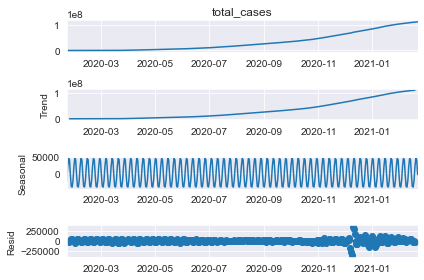

In [50]:
decomposed = sd(world_tot_cases)
decomposed.plot()
plt.show()

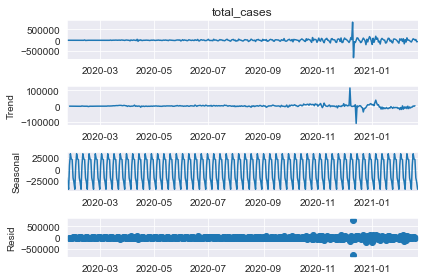

In [51]:
decomposed = sd(diff_world_tot_cases)
decomposed.plot()
plt.show()

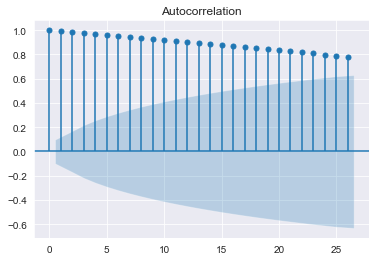

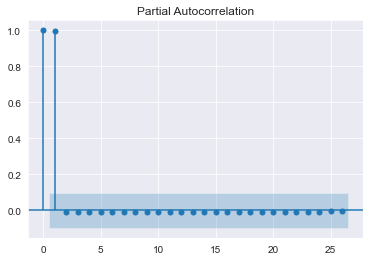

In [52]:
plot_acf(world_tot_cases)
plt.show()
plot_pacf(world_tot_cases)
plt.show()

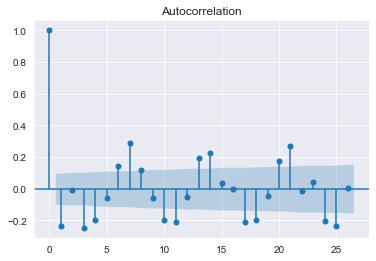

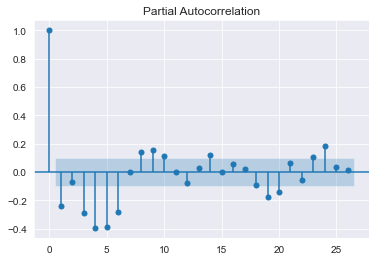

In [53]:
plot_acf(diff_world_tot_cases)
plt.show()
plot_pacf(diff_world_tot_cases)
plt.show()

In [54]:
world_train = world_data.total_cases[:-30]
world_test = world_data.total_cases[-30:]

diff_world_train = diff_world_tot_cases[:-30]
diff_world_test = diff_world_tot_cases[-30:]

print('Length of training set: ', len(train))
print('Length of testing set: ', len(test))
print('Length of differenced training set: ', len(diff_train))
print('Length of differenced testing set: ', len(diff_test))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  365
Length of differenced testing set:  30


In [55]:
model = ExponentialSmoothing(diff_world_train, seasonal_periods=7).fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [56]:
yhat_eswtc = model.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_eswtc, diff_world_test))

In [57]:
print('Root Mean Squared Error: ', rmse)
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=diff_world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_eswtc.index,
                         y=yhat_eswtc,
                         mode='lines',
                         name='Predicted Total Cases'))


fig.show()

Root Mean Squared Error:  69346.2834141562


In [58]:
model = ExponentialSmoothing(diff_world_tot_cases, seasonal_periods=7).fit()

predictions_eswtc = model.predict(393, 423)

fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.total_cases.diff().diff().dropna(),
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x = predictions_eswtc.index,
                         y=predictions_eswtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  367
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4565.507
Date:                Thu, 25 Mar 2021   AIC                           9137.015
Time:                        16:43:17   BIC                           9148.714
Sample:                    01-22-2020   HQIC                          9141.664
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3544      0.041      8.613      0.000       0.274       0.435
ma.L1         -0.8719      0.035    -25.272      0.000      -0.940      -0.804
sigma2      5.067e+09    6.6e-12   7.68e+20      0.0

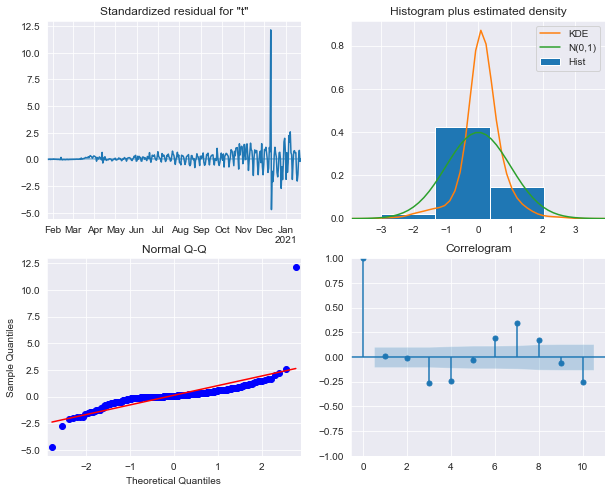

In [59]:
model = ARIMA(world_train, order=(1,2,1), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [60]:
yhat_arima_wtc = results.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_arima_wtc, world_test))

In [61]:
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wtc.index,
                         y=yhat_arima_wtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Squared Error:  2415435.2604513364


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  397
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -4944.363
Date:                Thu, 25 Mar 2021   AIC                           9894.726
Time:                        16:43:19   BIC                           9906.663
Sample:                    01-22-2020   HQIC                          9899.455
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3675      0.044      8.291      0.000       0.281       0.454
ma.L1         -0.8477      0.039    -21.508      0.000      -0.925      -0.770
sigma2      5.084e+09   3.92e-12    1.3e+21      0.0

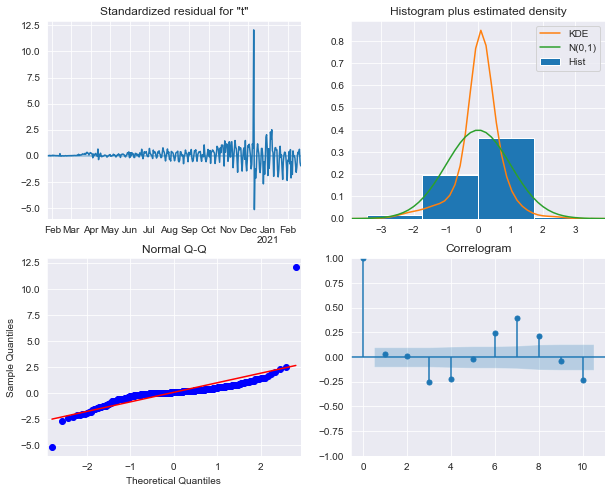

In [62]:
model = ARIMA(world_tot_cases, order=(1,2,1), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [63]:
predictions_arima_wtc = results.predict(394, 424)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wtc.index,
                         y=predictions_arima_wtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [64]:
auto_results_wtc = auto_arima(world_train, m=7)
auto_results_wtc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  367
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -4501.211
Date:                Thu, 25 Mar 2021   AIC                           9016.422
Time:                        16:55:10   BIC                           9043.722
Sample:                             0   HQIC                          9027.271
                                - 367                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1899      0.060     19.670      0.000       1.071       1.308
ar.L2         -0.9302      0.073    -12.693      0.000      -1.074      -0.787
ar.L3         -0.0533      0.055     -0.972      0.331      -0.161       0.054
ma.L1         -1.8946      0.060    -31.493      0.000      -2.013      -1.777
ma.L2          1.7320      0.090     19.225      0.000       1.555       1.909
ma.L3         -0.6099      0.061    -10.016      0.000      -0.729      -0.491
sigma2      3.436e+09    2.1e-10   1.64e+19      0.000    3.44e+09    3.44e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):            249399.62
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):             134.51   Skew:                             8.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       129.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.65e+33. Standard errors may be unstable.
"""

In [65]:
yhat_auto_wtc = auto_results_wtc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_auto_wtc, world_test))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wtc.index,
                         y=yhat_auto_wtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Squared Error:  2342470.8419664837


In [66]:
auto_results_wtc.fit(world_tot_cases)
predictions_awtc = auto_results_wtc.predict(n_periods = 30)

In [67]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wtc.index,
                         y=predictions_awtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [68]:
auto_results_diff_wtc = auto_arima(diff_world_train, m=7, stepwise=True)
auto_results_diff_wtc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -4498.692
Date:                Thu, 25 Mar 2021   AIC                           9019.385
Time:                        17:18:48   BIC                           9062.283
Sample:                             0   HQIC                          9036.433
                                - 365                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6306.4812   3727.591      1.692      0.091    -999.463    1.36e+04
ar.L1         -0.4135      0.228     -1.816      0.069      -0.860       0.033
ar.L2          0.2117      0.185      1.147      0.251      -0.150       0.574
ar.L3         -0.5938      0.156     -3.798      0.000      -0.900      -0.287
ar.L4         -0.8522      0.181     -4.715      0.000      -1.206      -0.498
ma.L1         -0.3092      0.225     -1.374      0.169      -0.750       0.132
ma.L2         -0.5285      0.335     -1.579      0.114      -1.185       0.127
ma.L3          0.6561      0.284      2.312      0.021       0.100       1.212
ma.L4          0.4235      0.245      1.731      0.083      -0.056       0.903
ma.L5         -0.5394      0.149     -3.610      0.000      -0.832      -0.247
sigma2      3.217e+09      0.088   3.66e+10      0.000    3.22e+09    3.22e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            256206.26
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              94.56   Skew:                             8.47
Prob(H) (two-sided):                  0.00   Kurtosis:                       131.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.06e+26. Standard errors may be unstable.
"""

In [69]:
yhat_diff_wtc = auto_results_diff_wtc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_diff_wtc, diff_world_test))

print('Root Mean Square Error: ', rmse)
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wtc.index,
                         y=yhat_diff_wtc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Square Error:  55730.9845676291


In [70]:
auto_results_diff_wtc.fit(diff_tot_cases)
predictions_diff_watc = auto_results_diff_tc.predict(n_periods=30)

In [71]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_world_tot_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wtc.index,
                         y=predictions_diff_watc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases, 
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_smoothed,
                         mode='lines',
                         name='New Cases Smoothed'))


fig.show()

In [73]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases, 
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_smoothed,
                         mode='lines',
                         name='New Cases Smoothed'))


fig.show()

In [74]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_per_million, 
                         mode = 'lines', 
                         name='New Cases Per Million'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_cases_smoothed_per_million,
                         mode='lines',
                         name='New Cases Smoothed Per Million'))


fig.show()

In [75]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_per_million, 
                         mode = 'lines', 
                         name='New Cases Per Million'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases_smoothed_per_million,
                         mode='lines',
                         name='New Cases Smoothed Per Million'))


fig.show()

In [76]:
results = adfuller(us_data.new_cases)
results[1]

0.5382638138932434

In [77]:
results = adfuller(us_data.new_cases.diff().dropna())
results[1]

0.00047699988275942565

In [78]:
new_cases = us_data.new_cases
diff_new_cases = us_data.new_cases.diff().dropna()

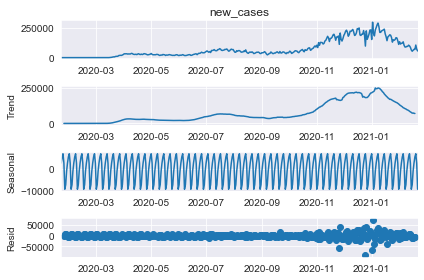

In [79]:
decomposed = sd(new_cases)
decomposed.plot()
plt.show()

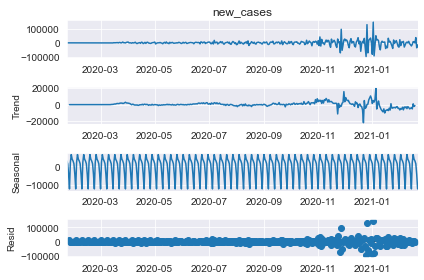

In [80]:
decomposed = sd(diff_new_cases)
decomposed.plot()
plt.show()

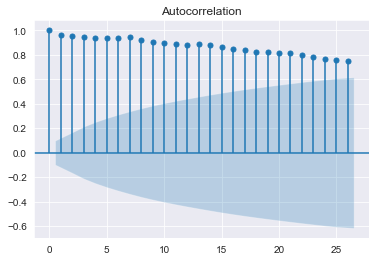

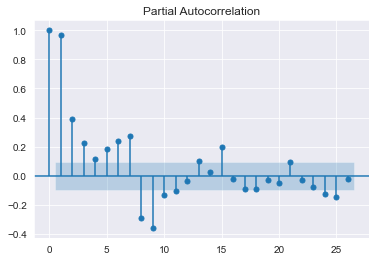

In [81]:
plot_acf(new_cases)
plt.show()
plot_pacf(new_cases)
plt.show()

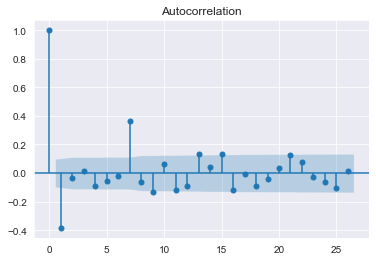

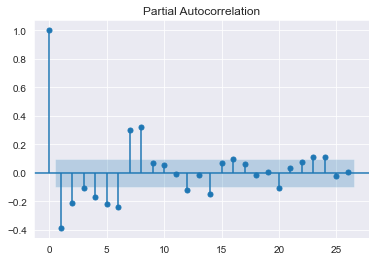

In [82]:
plot_acf(diff_new_cases)
plt.show()
plot_pacf(diff_new_cases)
plt.show()

In [83]:
train_nc = new_cases[:-30]
test_nc = new_cases[-30:]

diff_train_nc = diff_new_cases[:-30]
diff_test_nc = diff_new_cases[-30:]

print('Length of training set: ', len(train_nc))
print('Length of testing set: ', len(test_nc))
print('Length of differenced training set: ', len(diff_train_nc))
print('Length of differenced testing set: ', len(diff_test_nc))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  366
Length of differenced testing set:  30


In [84]:
model = Holt(diff_train_nc).fit()
yhat_hwnc = model.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_hwnc, diff_test_nc))

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [85]:
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()
fig.add_trace(go.Scatter(x=diff_new_cases.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=diff_test_nc.index,
                         y=yhat_hwnc,
                         mode='lines',
                         name='Predicted New Cases'))


fig.show()

Root Mean Squared Error:  18588.26231540552


In [86]:
model = Holt(diff_new_cases).fit()
predictions_hwnc = model.predict(395, 425)

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='Differenced New Cases'))
fig.add_trace(go.Scatter(x=predictions_hwnc.index,
                         y=predictions_hwnc,
                         mode='lines',
                         name='Predicted Differenced New Cases'))


fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  367
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -4063.035
Date:                Thu, 25 Mar 2021   AIC                           8138.069
Time:                        17:18:58   BIC                           8161.485
Sample:                    01-22-2020   HQIC                          8147.374
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6621      0.026    -25.833      0.000      -0.712      -0.612
ma.L2         -0.0453      0.035     -1.297      0.195      -0.114       0.023
ma.L3          0.1136      0.035      3.263      0.0

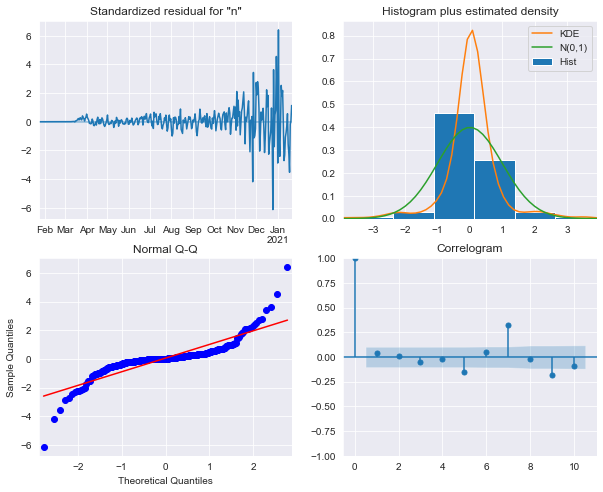

In [88]:
model = ARIMA(train_nc, order=(0,1,5), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [89]:
yhat_arima_nc = results.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_arima_nc, test_nc))

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_nc.index,
                         y=yhat_arima_nc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  397
Model:                 ARIMA(0, 1, 5)   Log Likelihood               -4398.817
Date:                Thu, 25 Mar 2021   AIC                           8809.634
Time:                        17:19:01   BIC                           8833.523
Sample:                    01-22-2020   HQIC                          8819.098
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6418      0.024    -26.647      0.000      -0.689      -0.595
ma.L2         -0.0845      0.033     -2.558      0.011      -0.149      -0.020
ma.L3          0.0960      0.033      2.881      0.0

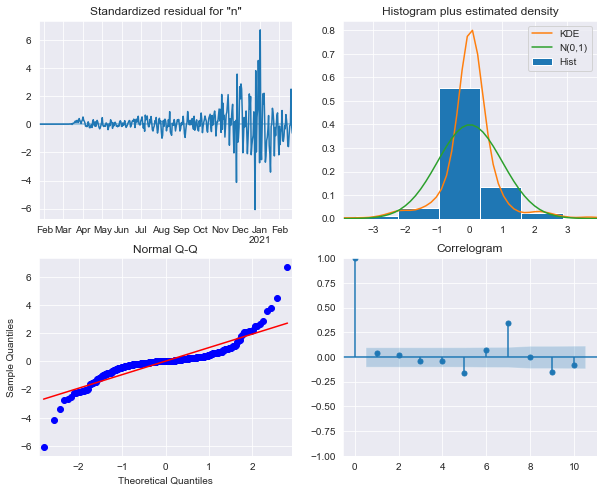

In [90]:
model = ARIMA(new_cases, order=(0,1,5), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [91]:
predictions_arima_nc = results.predict(397, 427)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_tc.index,
                         y=predictions_arima_nc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  366
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -4023.500
Date:                Thu, 25 Mar 2021   AIC                           8069.000
Time:                        17:19:04   BIC                           8111.929
Sample:                    01-23-2020   HQIC                          8086.058
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        519.1065    596.245      0.871      0.384    -649.512    1687.725
ar.L1         -0.4966      0.183     -2.720      0.007      -0.854      -0.139
ar.L2         -0.2527      0.097     -2.613      0.0

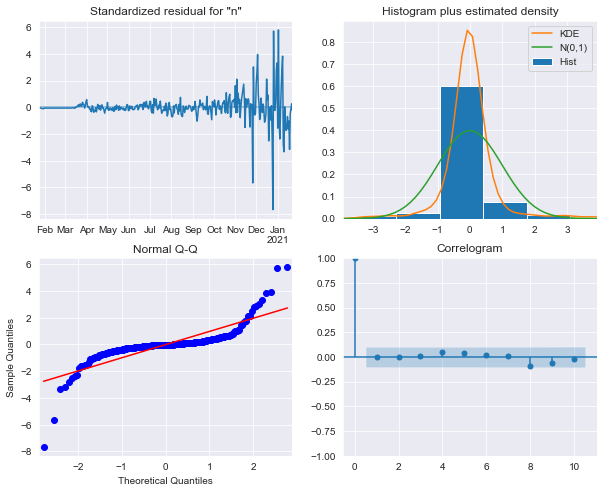

In [92]:
model = ARIMA(diff_train_nc, order=(8,0,1), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [93]:
yhat_diff_anc = results.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_arima_nc, diff_test_nc))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=yhat_diff_anc.index,
                         y=yhat_diff_anc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

Root Mean Squared Error:  179501.88008571707


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  396
Model:                 ARIMA(8, 0, 1)   Log Likelihood               -4349.603
Date:                Thu, 25 Mar 2021   AIC                           8721.205
Time:                        17:19:07   BIC                           8765.001
Sample:                    01-23-2020   HQIC                          8738.556
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        142.6641    686.648      0.208      0.835   -1203.140    1488.469
ar.L1         -0.4049      0.138     -2.941      0.003      -0.675      -0.135
ar.L2         -0.1799      0.069     -2.615      0.0

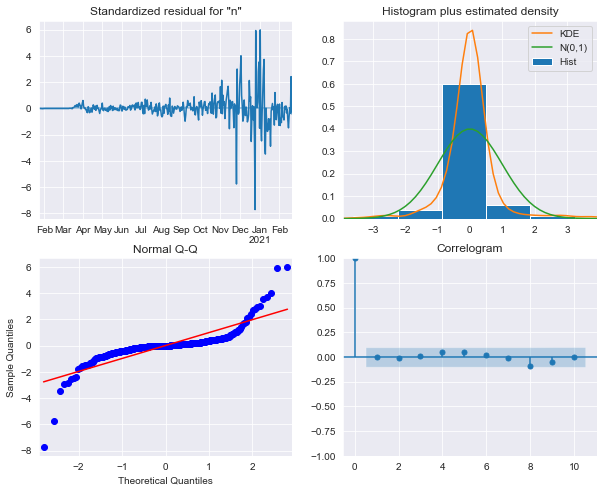

In [94]:
model = ARIMA(diff_new_cases, order=(8,0,1), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [95]:
predictions_diff_arima_nc = results.predict(394, 424)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='Total Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_nc.index,
                         y=predictions_diff_arima_nc,
                         mode='lines',
                         name='Predicted Total Cases'))

fig.show()

In [96]:
auto_results_nc = auto_arima(train_nc, m=7)
auto_results_nc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  367
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 52)   Log Likelihood               -4054.458
Date:                             Thu, 25 Mar 2021   AIC                           8120.917
Time:                                     17:21:59   BIC                           8144.333
Sample:                                          0   HQIC                          8130.222
                                             - 367                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1320.8227    698.237      1.892      0.059     -47.697    2689.342
ar.L1         -0.8770      0.050    -17.510      0.000      -0.975      -0.779
ma.L1          0.3226      0.049      6.532      0.000       0.226       0.419
ma.L2         -0.5807      0.027    -21.544      0.000      -0.633      -0.528
ar.S.L52      -0.3590      0.039     -9.119      0.000      -0.436      -0.282
sigma2      2.628e+08      0.005   5.78e+10      0.000    2.63e+08    2.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              3046.58
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              91.88   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+26. Standard errors may be unstable.
"""

In [97]:
yhat_auto_nc = auto_results_nc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_auto_nc, test_nc))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_nc.index,
                         y=yhat_auto_nc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

Root Mean Squared Error:  87507.13621676831


In [98]:
auto_results_nc.fit(new_cases)
predictions_anc = auto_results_nc.predict(30)

In [99]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = new_cases,
                         mode = 'lines', 
                         name='Differenced New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_nc.index,
                         y=predictions_anc,
                         mode='lines',
                         name='Predicted Differenced New Cases'))

fig.show()

In [100]:
auto_results_diff_nc = auto_arima(diff_train_nc, m=7)
auto_results_diff_nc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  366
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood               -4054.671
Date:                             Thu, 25 Mar 2021   AIC                           8121.343
Time:                                     17:24:31   BIC                           8144.759
Sample:                                          0   HQIC                          8130.647
                                             - 366                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1320.8227    699.474      1.888      0.059     -50.120    2691.766
ar.L1         -0.8768      0.050    -17.483      0.000      -0.975      -0.779
ma.L1          0.3230      0.049      6.529      0.000       0.226       0.420
ma.L2         -0.5801      0.027    -21.528      0.000      -0.633      -0.527
ar.S.L52      -0.3569      0.039     -9.065      0.000      -0.434      -0.280
sigma2      2.628e+08      0.005    5.8e+10      0.000    2.63e+08    2.63e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              3043.54
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              92.12   Skew:                             0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.11e+26. Standard errors may be unstable.
"""

In [101]:
yhat_diff_auto_nc = auto_results_diff_nc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_diff_auto_nc, diff_test))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='Differenced New Cases'))
fig.add_trace(go.Scatter(x=test.index[:-1],
                         y=yhat_diff_auto_nc,
                         mode='lines',
                         name='Predicted Differenced New Cases'))

fig.show()

Root Mean Squared Error:  23012.87550059912


In [102]:
auto_results_diff_nc.fit(diff_new_cases)
predictions_diff_anc = auto_results_diff_nc.predict(30)

In [103]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_new_cases,
                         mode = 'lines', 
                         name='Differenced New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_nc.index,
                         y=predictions_diff_anc,
                         mode='lines',
                         name='Predicted Differenced New Cases'))

fig.show()

In [104]:
results = adfuller(world_data.new_cases)
results[1]

0.6031794952887767

As expected, the time series is not stationary. I will check for stationarity on the differenced time series, and if needed on the time series differenced twice.

In [105]:
results = adfuller(world_data.new_cases.diff().dropna())
results[1]

7.01569031732402e-05

In [106]:
world_new_cases = world_data.new_cases
diff_world_new_cases = world_data.new_cases.diff().dropna()

In [107]:
px.line(diff_world_new_cases)

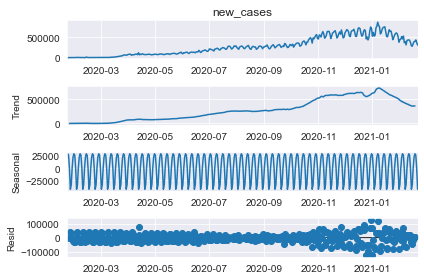

In [108]:
decomposed = sd(world_new_cases)
decomposed.plot()
plt.show()

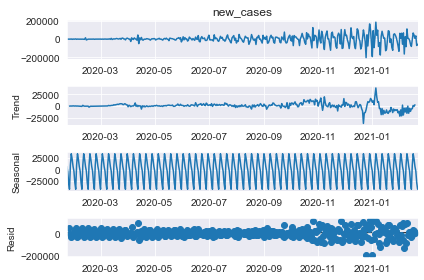

In [109]:
decomposed = sd(diff_world_new_cases)
decomposed.plot()
plt.show()

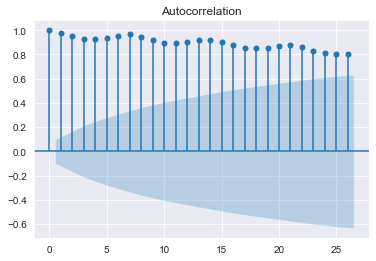

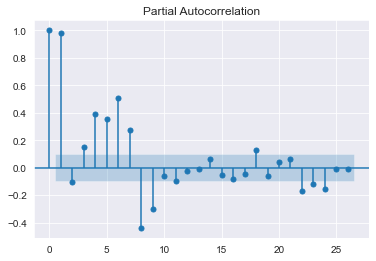

In [110]:
plot_acf(world_new_cases)
plt.show()
plot_pacf(world_new_cases)
plt.show()

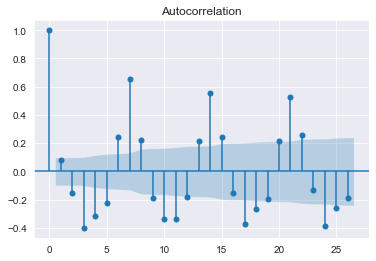

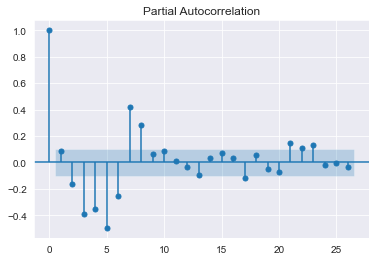

In [111]:
plot_acf(diff_world_new_cases)
plt.show()
plot_pacf(diff_world_new_cases)
plt.show()

In [112]:
world_train_nc = world_data.new_cases[:-30]
world_test_nc = world_data.new_cases[-30:]

diff_world_train_nc = diff_world_new_cases[:-30]
diff_world_test_nc = diff_world_new_cases[-30:]

print('Length of training set: ', len(world_train_nc))
print('Length of testing set: ', len(world_test_nc))
print('Length of differenced training set: ', len(diff_world_train_nc))
print('Length of differenced testing set: ', len(diff_world_test_nc))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  366
Length of differenced testing set:  30


In [113]:
model = ExponentialSmoothing(diff_world_train_nc, seasonal_periods=7).fit()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [114]:
yhat_eswnc = model.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_eswnc, diff_world_test_nc))

In [115]:
print('Root Mean Squared Error: ', rmse)
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=diff_world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_eswnc.index,
                         y=yhat_eswnc,
                         mode='lines',
                         name='Predicted New Cases'))


fig.show()

Root Mean Squared Error:  69346.59232346743


In [116]:
model = ExponentialSmoothing(diff_world_new_cases, seasonal_periods=7).fit()

predictions_eswnc = model.predict(393, 423)

fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_cases.diff().diff().dropna(),
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x = predictions_eswnc.index,
                         y=predictions_eswnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  367
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4318.401
Date:                Thu, 25 Mar 2021   AIC                           8646.802
Time:                        17:24:47   BIC                           8666.315
Sample:                    01-22-2020   HQIC                          8654.556
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2172      0.020     60.106      0.000       1.178       1.257
ar.L2         -0.8966      0.017    -52.007      0.000      -0.930      -0.863
ma.L1         -1.4565      0.024    -60.509      0.0

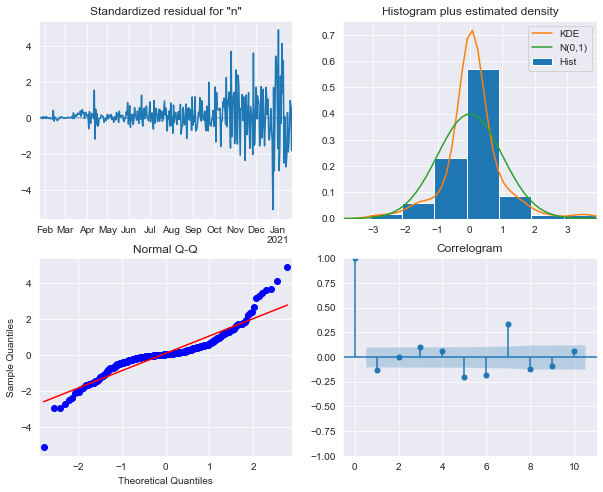

In [117]:
model = ARIMA(world_train_nc, order=(2,1,2), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [118]:
yhat_arima_wnc = results.predict(365, 394)
rmse = sqrt(mean_squared_error(yhat_arima_wnc, world_test_nc))

In [119]:
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wnc.index,
                         y=yhat_arima_wnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

Root Mean Squared Error:  201347.20849917238


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:              new_cases   No. Observations:                  397
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4695.310
Date:                Thu, 25 Mar 2021   AIC                           9400.619
Time:                        17:24:52   BIC                           9420.526
Sample:                    01-22-2020   HQIC                          9408.506
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2106      0.022     55.294      0.000       1.168       1.253
ar.L2         -0.8986      0.019    -47.344      0.000      -0.936      -0.861
ma.L1         -1.4440      0.026    -56.580      0.0

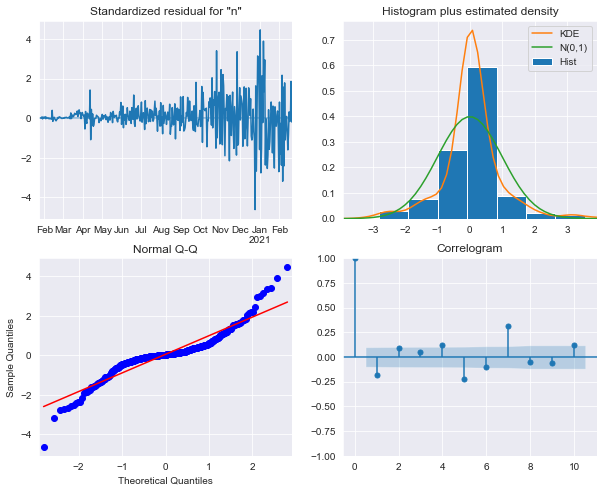

In [120]:
model = ARIMA(world_new_cases, order=(2,1,2), enforce_stationarity=True, enforce_invertibility=True, freq='D')
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [121]:
predictions_arima_wnc = results.predict(394, 424)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wnc.index,
                         y=predictions_arima_wnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

In [122]:
auto_results_wnc = auto_arima(world_train_nc, m=7)
auto_results_wnc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  367
Model:               SARIMAX(5, 1, 5)   Log Likelihood               -4269.226
Date:                Thu, 25 Mar 2021   AIC                           8562.453
Time:                        17:49:53   BIC                           8609.284
Sample:                             0   HQIC                          8581.062
                                - 367                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3824.2119   2123.182      1.801      0.072    -337.148    7985.572
ar.L1          0.6770      0.168      4.036      0.000       0.348       1.006
ar.L2         -1.3282      0.147     -9.060      0.000      -1.615      -1.041
ar.L3          0.5700      0.239      2.390      0.017       0.102       1.038
ar.L4         -0.8381      0.127     -6.598      0.000      -1.087      -0.589
ar.L5         -0.1547      0.152     -1.021      0.307      -0.452       0.142
ma.L1         -1.0860      0.168     -6.457      0.000      -1.416      -0.756
ma.L2          1.4730      0.177      8.313      0.000       1.126       1.820
ma.L3         -1.0943      0.218     -5.011      0.000      -1.522      -0.666
ma.L4          0.9149      0.139      6.573      0.000       0.642       1.188
ma.L5         -0.2510      0.113     -2.220      0.026      -0.473      -0.029
sigma2      9.742e+08      0.003   3.46e+11      0.000    9.74e+08    9.74e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2647.65
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              35.01   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.11e+27. Standard errors may be unstable.
"""

In [123]:
yhat_auto_wnc = auto_results_wnc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_auto_wnc, world_test_nc))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wtc.index,
                         y=yhat_auto_wnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

Root Mean Squared Error:  206390.6608788676


In [124]:
auto_results_wnc.fit(world_new_cases)
predictions_awnc = auto_results_wnc.predict(n_periods = 30)

In [125]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wnc.index,
                         y=predictions_awnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

In [126]:
auto_results_diff_wnc = auto_arima(diff_world_train_nc, m=7, stepwise=True)
auto_results_diff_wnc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(5, 0, 5)   Log Likelihood               -4269.774
Date:                Thu, 25 Mar 2021   AIC                           8563.548
Time:                        18:07:48   BIC                           8610.379
Sample:                             0   HQIC                          8582.157
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3824.2119   2107.446      1.815      0.070    -306.306    7954.730
ar.L1          0.6815      0.167      4.082      0.000       0.354       1.009
ar.L2         -1.3325      0.146     -9.158      0.000      -1.618      -1.047
ar.L3          0.5790      0.237      2.442      0.015       0.114       1.044
ar.L4         -0.8424      0.127     -6.652      0.000      -1.091      -0.594
ar.L5         -0.1491      0.151     -0.988      0.323      -0.445       0.147
ma.L1         -1.0911      0.167     -6.532      0.000      -1.418      -0.764
ma.L2          1.4794      0.176      8.429      0.000       1.135       1.823
ma.L3         -1.1044      0.216     -5.114      0.000      -1.528      -0.681
ma.L4          0.9226      0.138      6.681      0.000       0.652       1.193
ma.L5         -0.2567      0.113     -2.280      0.023      -0.477      -0.036
sigma2      9.742e+08      0.002   3.97e+11      0.000    9.74e+08    9.74e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2658.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              35.05   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.05e+27. Standard errors may be unstable.
"""

In [127]:
yhat_diff_wnc = auto_results_diff_wnc.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_diff_wnc, diff_world_test_nc))

print('Root Mean Square Error: ', rmse)
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=yhat_arima_wnc.index,
                         y=yhat_diff_wnc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

Root Mean Square Error:  51674.44421045292


In [128]:
auto_results_diff_wnc.fit(diff_new_cases)
predictions_diff_wanc = auto_results_diff_nc.predict(n_periods=30)

In [129]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_world_new_cases,
                         mode = 'lines', 
                         name='New Cases'))
fig.add_trace(go.Scatter(x=predictions_arima_wnc.index,
                         y=predictions_diff_wanc,
                         mode='lines',
                         name='Predicted New Cases'))

fig.show()

## Total and New Deaths

In [130]:
px.line(us_data.total_deaths)

In [131]:
px.line(world_data.total_deaths)

In [132]:
px.line(us_data.total_deaths_per_million)

In [133]:
px.line(world_data.total_deaths_per_million)

In [134]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_deaths, 
                         mode = 'lines', 
                         name='New Deaths'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_deaths_smoothed,
                         mode='lines',
                         name='New Deaths Smoothed'))


fig.show()

In [135]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_deaths, 
                         mode = 'lines', 
                         name='New Deaths'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_deaths_smoothed,
                         mode='lines',
                         name='New Deaths Smoothed'))


fig.show()

In [136]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_deaths_per_million, 
                         mode = 'lines', 
                         name='New Deaths Per Million'))
fig.add_trace(go.Scatter(x=us_data.index,
                         y=us_data.new_deaths_smoothed_per_million,
                         mode='lines',
                         name='New Deaths Per Million Smoothed'))


fig.show()

AttributeError: 'DataFrame' object has no attribute 'new_deaths_smoothed_per_million'

In [137]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_deaths_per_million, 
                         mode = 'lines', 
                         name='New Deaths Per Million'))
fig.add_trace(go.Scatter(x=world_data.index,
                         y=world_data.new_deaths_smoothed_per_million,
                         mode='lines',
                         name='New Deaths Per Million Smoothed'))


fig.show()

In [138]:
results = adfuller(us_data.total_deaths)
results[1]

0.9936922238489087

In [141]:
results = adfuller(us_data.total_deaths.diff().diff().dropna())
results[1]

0.0014173885329262694

In [142]:
total_deaths = us_data.total_deaths
diff_total_deaths = us_data.total_deaths.diff().diff().dropna()

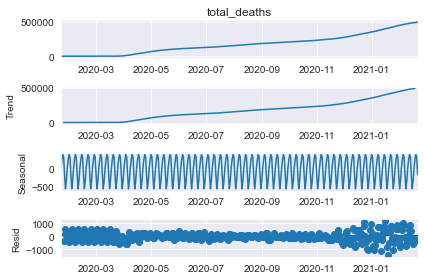

In [144]:
decomposed = sd(total_deaths)
decomposed.plot()
plt.show()

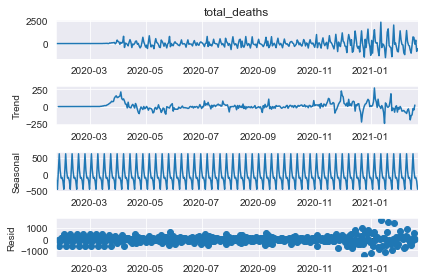

In [145]:
decomposed = sd(diff_total_deaths)
decomposed.plot()
plt.show()

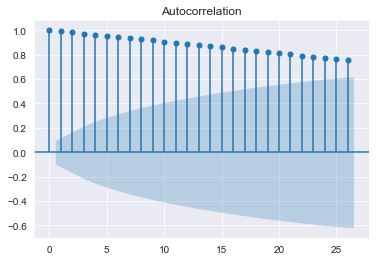

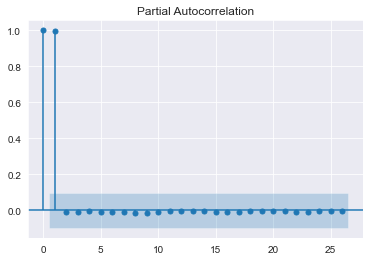

In [147]:
plot_acf(total_deaths)
plt.show()
plot_pacf(total_deaths)
plt.show()

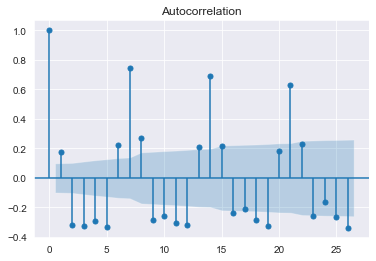

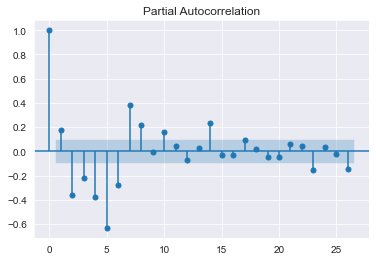

In [148]:
plot_acf(diff_total_deaths)
plt.show()
plot_pacf(diff_total_deaths)
plt.show()

In [149]:
train_td = total_deaths[:-30]
test_td = total_deaths[-30:]

In [150]:
diff_train_td = diff_total_deaths[:-30]
diff_test_td = diff_total_deaths[-30:]

In [152]:
print('Length of training set: ', len(train_td))
print('Length of testing set: ', len(test_td))
print('Length of differenced training set: ', len(diff_train_td))
print('Length of differenced testing set: ', len(diff_test_td))

Length of training set:  367
Length of testing set:  30
Length of differenced training set:  365
Length of differenced testing set:  30


In [153]:
model = Holt(diff_train_td).fit()
yhat_hwtd = model.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_hwtd, diff_test_td))

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [154]:
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()
fig.add_trace(go.Scatter(x=diff_total_deaths.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=diff_test_td.index,
                         y=yhat_hwtd,
                         mode='lines',
                         name='Predicted Total Deaths'))


fig.show()

Root Mean Squared Error:  806.8024052000796


In [155]:
model = Holt(diff_total_deaths).fit()
predictions_hwtd = model.predict(395, 425)

fig = go.Figure()
fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Differenced Total Deaths'))
fig.add_trace(go.Scatter(x=predictions_hwtd.index,
                         y=predictions_hwtd,
                         mode='lines',
                         name='Predicted Differenced Total Deaths'))


fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning:

After 0.13 initialization must be handled at model creation

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:           total_deaths   No. Observations:                  367
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2610.788
Date:                Thu, 25 Mar 2021   AIC                           5231.577
Time:                        23:20:35   BIC                           5251.076
Sample:                    01-22-2020   HQIC                          5239.326
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2189      0.021     59.230      0.000       1.179       1.259
ar.L2         -0.9014      0.017    -54.317      0.000      -0.934      -0.869
ma.L1         -1.4638      0.035    -41.271      0.0

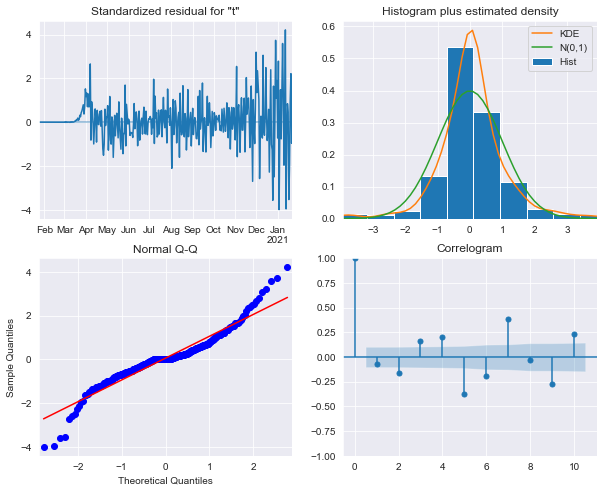

In [156]:
model = ARIMA(train_td, order=(2,2,2), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [157]:
yhat_arima_td = results.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_arima_td, test_td))

print('Root Mean Squared Error:', rmse)
fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=yhat_arima_td.index,
                         y=yhat_arima_td,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

Root Mean Squared Error: 4946.666923829986


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:           total_deaths   No. Observations:                  397
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -2844.006
Date:                Thu, 25 Mar 2021   AIC                           5698.012
Time:                        23:24:43   BIC                           5717.907
Sample:                    01-22-2020   HQIC                          5705.895
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2217      0.019     64.467      0.000       1.185       1.259
ar.L2         -0.9069      0.016    -58.050      0.000      -0.938      -0.876
ma.L1         -1.4758      0.033    -44.447      0.0

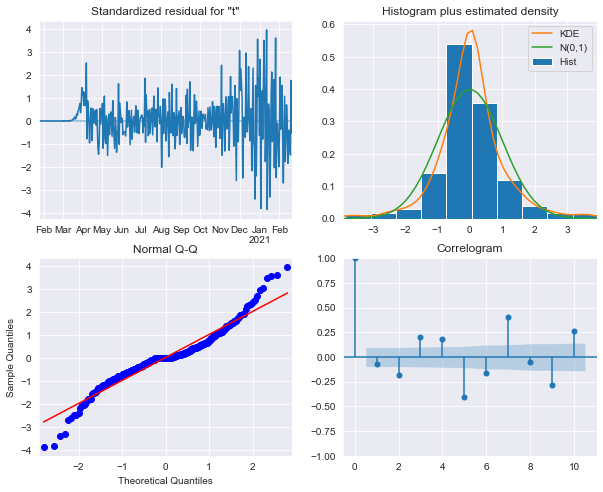

In [158]:
model = ARIMA(total_deaths, order=(2,2,2), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [159]:
predictions_arima_td = results.predict(397, 427)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=predictions_arima_td.index,
                         y=predictions_arima_td,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:           total_deaths   No. Observations:                  365
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2610.329
Date:                Thu, 25 Mar 2021   AIC                           5232.658
Time:                        23:26:34   BIC                           5256.058
Sample:                    01-24-2020   HQIC                          5241.958
                         - 01-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8711      7.882      0.872      0.383      -8.577      22.319
ar.L1          1.2176      0.021     58.591      0.000       1.177       1.258
ar.L2         -0.8998      0.016    -54.806      0.0

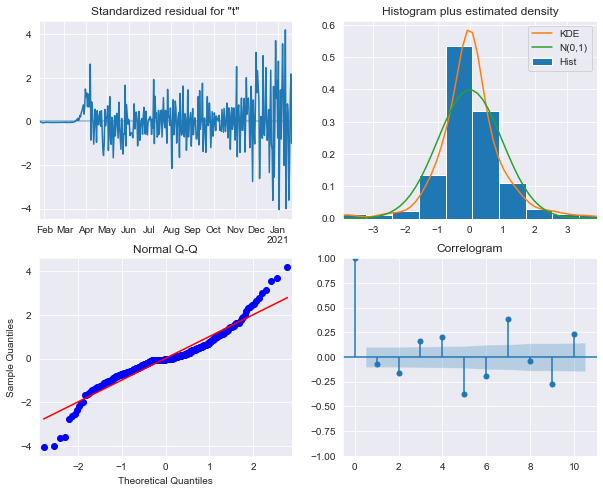

In [160]:
model = ARIMA(diff_train_td, order=(2,0,2), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [162]:
yhat_diff_atd = results.predict(366, 395)
rmse = sqrt(mean_squared_error(yhat_diff_atd, diff_test_td))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=yhat_diff_atd.index,
                         y=yhat_diff_atd,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

Root Mean Squared Error:  642.7899851443674


/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/rlathbury/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:           total_deaths   No. Observations:                  395
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -2844.012
Date:                Thu, 25 Mar 2021   AIC                           5700.025
Time:                        23:29:21   BIC                           5723.898
Sample:                    01-24-2020   HQIC                          5709.483
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0896      7.966      0.764      0.445      -9.523      21.702
ar.L1          1.2211      0.019     63.804      0.000       1.184       1.259
ar.L2         -0.9061      0.015    -58.662      0.0

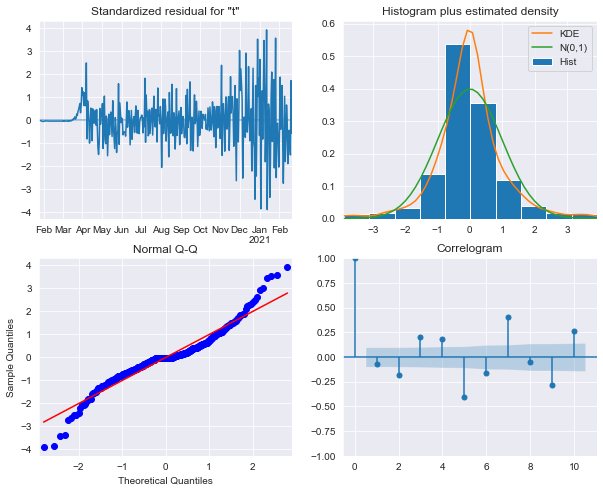

In [163]:
model = ARIMA(diff_total_deaths, order=(2,0,2), enforce_stationarity=True, enforce_invertibility=True)
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10,8))
plt.show()

In [164]:
predictions_diff_arima_td = results.predict(394, 424)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=predictions_arima_td.index,
                         y=predictions_diff_arima_td,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

In [166]:
auto_results_td = auto_arima(train_td, m=7)
auto_results_td.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  367
Model:             SARIMAX(3, 2, 2)x(2, 0, [1], 7)   Log Likelihood               -2524.396
Date:                             Thu, 25 Mar 2021   AIC                           5066.791
Time:                                     23:45:23   BIC                           5101.890
Sample:                                          0   HQIC                          5080.740
                                             - 367                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0935      0.117     -0.796      0.426      -0.324       0.137
ar.L2          0.2022      0.104      1.942      0.052      -0.002       0.406
ar.L3         -0.2695      0.054     -4.953      0.000      -0.376      -0.163
ma.L1         -0.1608      0.125     -1.288      0.198      -0.405       0.084
ma.L2         -0.3923      0.133     -2.947      0.003      -0.653      -0.131
ar.S.L7        1.2501      0.092     13.581      0.000       1.070       1.430
ar.S.L14      -0.2626      0.082     -3.183      0.001      -0.424      -0.101
ma.S.L7       -0.7999      0.074    -10.797      0.000      -0.945      -0.655
sigma2      5.829e+04   2629.582     22.168      0.000    5.31e+04    6.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.45   Jarque-Bera (JB):               596.78
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [167]:
yhat_auto_td = auto_results_td.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_auto_td, test_td))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=yhat_arima_td.index,
                         y=yhat_auto_td,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

Root Mean Squared Error:  8361.508207951747


In [168]:
auto_results_td.fit(total_deaths)
predictions_atd = auto_results_td.predict(30)

fig = go.Figure()

fig.add_trace(go.Scatter(x = us_data.index,
                         y = total_deaths,
                         mode = 'lines', 
                         name='Total Deaths'))
fig.add_trace(go.Scatter(x=predictions_arima_td.index,
                         y=predictions_atd,
                         mode='lines',
                         name='Predicted Total Deaths'))

fig.show()

In [169]:
auto_results_diff_td = auto_arima(diff_train_td, m=7)
auto_results_diff_td.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  365
Model:             SARIMAX(5, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -2522.054
Date:                                Thu, 25 Mar 2021   AIC                           5064.108
Time:                                        23:48:22   BIC                           5103.107
Sample:                                             0   HQIC                          5079.607
                                                - 365                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0522      0.163      0.321      0.749      -0.267       0.371
ar.L2         -0.1644      0.061     -2.674      0.007      -0.285      -0.044
ar.L3         -0.3260      0.060     -5.407      0.000      -0.444      -0.208
ar.L4         -0.0635      0.075     -0.847      0.397      -0.210       0.083
ar.L5         -0.1871      0.053     -3.515      0.000      -0.291      -0.083
ma.L1         -0.3326      0.158     -2.105      0.035      -0.642      -0.023
ar.S.L7        0.9854      0.017     58.299      0.000       0.952       1.019
ma.S.L7       -0.6128      0.042    -14.697      0.000      -0.694      -0.531
ma.S.L14      -0.1558      0.044     -3.574      0.000      -0.241      -0.070
sigma2      5.695e+04   2622.858     21.713      0.000    5.18e+04    6.21e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               596.96
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.78   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
yhat_diff_auto_td = auto_results_diff_td.predict(n_periods = 30)
rmse = sqrt(mean_squared_error(yhat_diff_auto_td, diff_test_td))
print('Root Mean Squared Error: ', rmse)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Differenced Total Deaths'))
fig.add_trace(go.Scatter(x=yhat_arima_td.index,
                         y=yhat_diff_auto_td,
                         mode='lines',
                         name='Predicted Differenced Total Deaths'))

fig.show()

Root Mean Squared Error:  1157.01725967854


In [171]:
auto_results_diff_td.fit(diff_total_deaths)
predictions_diff_atd = auto_results_diff_td.predict(30)

fig = go.Figure()

fig.add_trace(go.Scatter(x=us_data.index,
                         y=diff_total_deaths,
                         mode = 'lines', 
                         name='Differenced Total Deaths'))
fig.add_trace(go.Scatter(x=predictions_arima_td.index,
                         y=predictions_diff_atd,
                         mode='lines',
                         name='Predicted Differenced Total Deaths'))

fig.show()

## Other

In [ ]:
px.line(us_data.total_vaccinations.dropna())

In [ ]:
px.line(world_data.total_vaccinations.dropna())

In [ ]:
px.line(us_data.total_vaccinations_per_hundred.dropna())

In [ ]:
px.line(world_data.total_vaccinations_per_hundred.dropna())

In [ ]:
px.line(us_data.positive_rate)

In [ ]:
px.line(us_data.people_fully_vaccinated.dropna())